# Extract the PSF  some stars in HD163466 field
=====================================================================

- Creation : Friday 2016 June 24th
- Author Sylvie Dagoret-Campagne 
- affiliation : LAL/IN2P3/CNRS

PSF of HD163466 without grating


## 1) Import package

In [184]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [185]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [186]:
#photutils.test()

In [187]:
from scipy import stats 
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [188]:
import libMonocamBaseImages           # my tool library written to do that CCD reduction

In [189]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-06-29 12:23:06.372517
fits date format for the analysis :  2016-06-29T12:23:06


## 3) Configuration of the input file

- HD158485_grat_science.fits
- HD159222_grat_science.fits
- HD163466_grat_science.fits


In [190]:
#object_name='HD158485_grat_20'
#object_name='HD159222_grat'
object_name='HD163466_none'

In [191]:
path='./HD163466_none'
basefilename='AssScImHD163466_none_10.fits' # check master bias
filename=os.path.join(path,basefilename)

## 4) Read the images

In [192]:
allimages = []
ccd_chan = ccdproc.CCDData.read(filename, hdu=0,unit='adu') 
allimages.append(ccd_chan)

data=ccd_chan.data

## 5) Shows the images

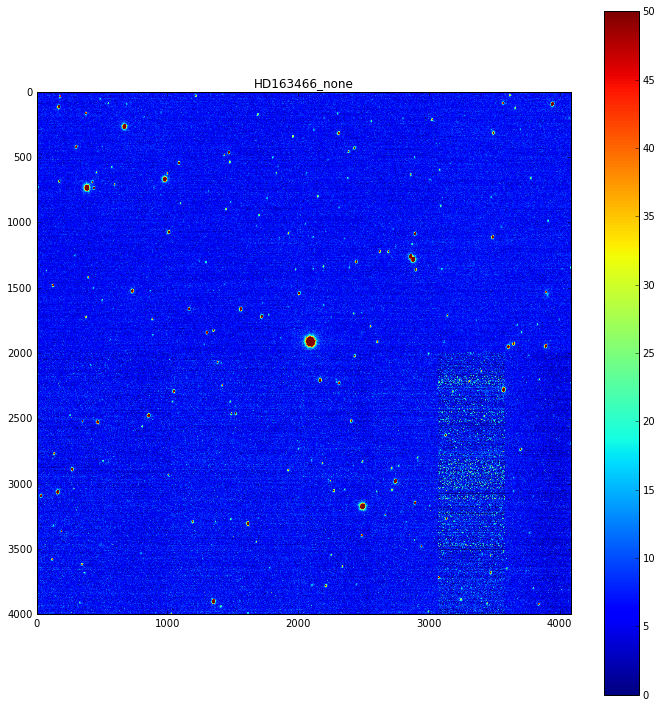

In [193]:
fig, ax = plt.subplots(figsize=(10, 10))
img=ax.imshow(ccd_chan,vmin=0,vmax=50.)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)
#plt.savefig(outputfigfilename3)

# 6) Subtract background

code implemented from photutil information there:
https://photutils.readthedocs.io/en/latest/photutils/background.html#

In [194]:
from photutils.background import Background2D
bkg = Background2D(data, (100, 100), filter_size=(3, 3),method='median')

### does the background varies over the field of view ?

In [195]:
print('median background = ',bkg.background_median)
print('median rms = ',bkg.background_rms_median)

('median background = ', 6.20630903486507)
('median rms = ', 2.3887881445763961)


### Radiography of the residual background

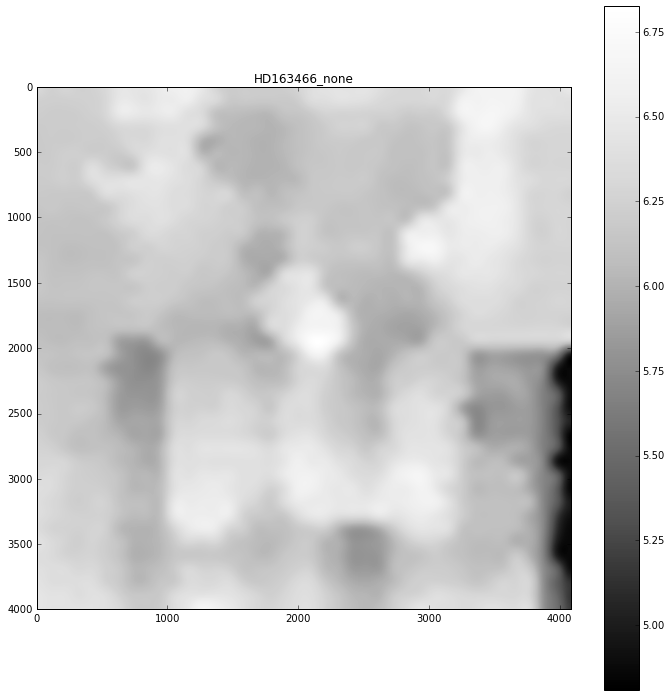

In [196]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
img=ax.imshow(bkg.background, cmap='Greys_r')
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)

### Now subtract residual the background

In [197]:
data2=data - bkg.background

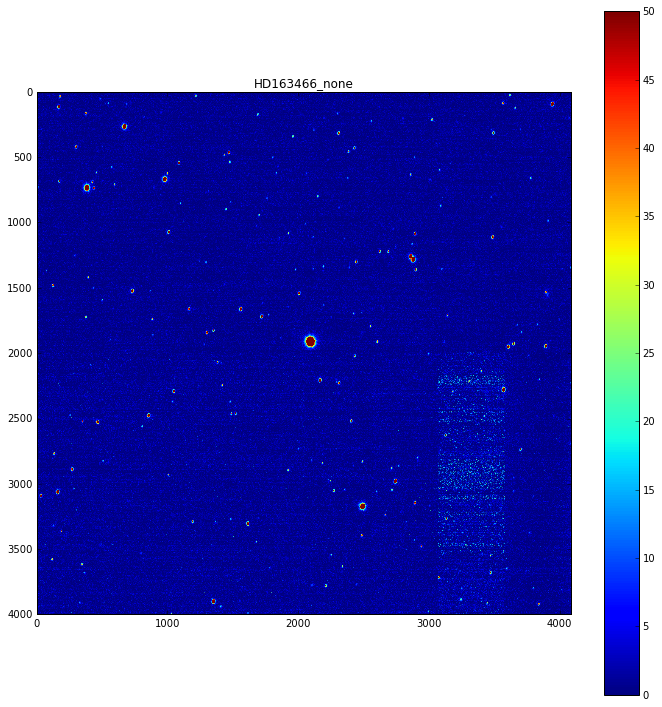

In [198]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
img=plt.imshow(data2, vmin=0,vmax=50.)
#img=plt.imshow(data2)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)

## 8.) Compute signal and noise

In [199]:
mean, median, std = sigma_clipped_stats(data2, sigma=10.0, iters=5)    
print(mean, median, std)    

(0.076298673924951016, 0.0086750460238134153, 2.8133004880688368)


In [200]:
sources = daofind(data2 - median, fwhm=3.0, threshold=50.*std)
sources.sort('flux')
print(sources)   

 id   xcentroid     ycentroid   ...      peak          flux           mag       
--- ------------- ------------- ... ------------- ------------- ----------------
  2  3937.9177515 100.320729815 ... 593.709115319 1.01092816606 -0.0118007421122
 17 1557.66882057 1667.35070553 ... 475.896856466  1.0187184498 -0.0201354291198
 22 3888.01691707 1947.03175825 ... 419.427258019  1.0437204002  -0.046460430297
 16 1557.98204142 1663.51163157 ...  622.65455997 1.12440547489  -0.127307378956
 18 1717.63917805 1720.18045976 ... 480.498885837 1.13913122628  -0.141434392656
 10 1006.71701502 1074.03043814 ... 423.749342621 1.17044462438  -0.170877178372
 12 2854.88080672 1265.04349523 ... 825.539350525 1.23039082445  -0.225107709372
 24  2164.2106814 2206.40961665 ... 587.909607029 1.35480951888   -0.32969559833
 34 2487.87237322  3183.7776964 ... 1608.81881009 1.46495301509   -0.41455923986
 29 2739.01675668 2984.48505736 ... 841.528114284 1.46864059197  -0.417288818917
...           ...           

In [201]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,3937.9177515,100.320729815,0.336207984582,-0.174672414195,-0.473327131882,25.0,0.0,593.709115319,1.01092816606,-0.0118007421122
17,1557.66882057,1667.35070553,0.417499499291,0.286818202033,0.43076261982,25.0,0.0,475.896856466,1.0187184498,-0.0201354291198
22,3888.01691707,1947.03175825,0.273413673534,-0.401046609763,0.332927701905,25.0,0.0,419.427258019,1.0437204002,-0.046460430297
16,1557.98204142,1663.51163157,0.465195941876,-0.11468830723,0.600047351948,25.0,0.0,622.65455997,1.12440547489,-0.127307378956
18,1717.63917805,1720.18045976,0.500981968017,-0.418705470432,0.385549982732,25.0,0.0,480.498885837,1.13913122628,-0.141434392656
10,1006.71701502,1074.03043814,0.499563079534,-0.715344385148,0.291909272277,25.0,0.0,423.749342621,1.17044462438,-0.170877178372
12,2854.88080672,1265.04349523,0.346416911754,0.137141610222,0.0118558292284,25.0,0.0,825.539350525,1.23039082445,-0.225107709372
24,2164.2106814,2206.40961665,0.482405390006,-0.862896750333,0.015192669553,25.0,0.0,587.909607029,1.35480951888,-0.32969559833
34,2487.87237322,3183.7776964,0.380348244445,-0.0443635288021,0.942639748563,25.0,0.0,1608.81881009,1.46495301509,-0.41455923986


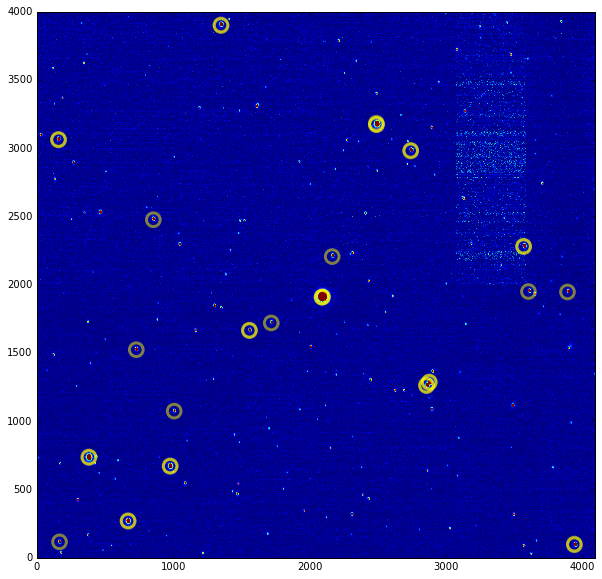

In [202]:
fig, ax = plt.subplots(figsize=(10, 10))
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=50.)
norm = ImageNormalize(stretch=SqrtStretch())
ax.imshow(data2,vmin=0,vmax=50.,origin='lower')
#ax.imshow(data, cmap='Greys', origin='lower', norm=norm)
apertures.plot(color='yellow', lw=3., alpha=0.5)

### For example shows the 25 first stars

In [203]:
NBSTARS=25
XX=np.zeros(NBSTARS)
YY=np.zeros(NBSTARS)
selected_stars=sources.as_array()
for istar in range(NBSTARS):
    XX[istar] = int(selected_stars[istar][1])
    YY[istar] = int(selected_stars[istar][2])   
    print XX[istar],YY[istar]

3937.0 100.0
1557.0 1667.0
3888.0 1947.0
1557.0 1663.0
1717.0 1720.0
1006.0 1074.0
2854.0 1265.0
2164.0 2206.0
2487.0 3183.0
2739.0 2984.0
729.0 1523.0
166.0 116.0
3602.0 1950.0
159.0 3064.0
853.0 2476.0
3566.0 2282.0
3938.0 94.0
2739.0 2979.0
1349.0 3903.0
159.0 3060.0
3567.0 2278.0
2855.0 1260.0
1349.0 3898.0
2875.0 1288.0
977.0 673.0


## Work with one PSF of one star

In [204]:
# Extract the plot of a PSF
index=2

onepsf=data2[YY[index]-10:YY[index]+10,XX[index]-10:XX[index]+10]
onepsfX=onepsf.sum(axis=0)
onepsfY=onepsf.sum(axis=1)

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


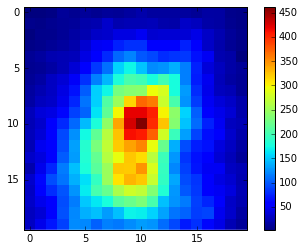

In [205]:
im=plt.imshow(onepsf,interpolation='None')
#im=plt.imshow(onepsf)
plt.colorbar(im)

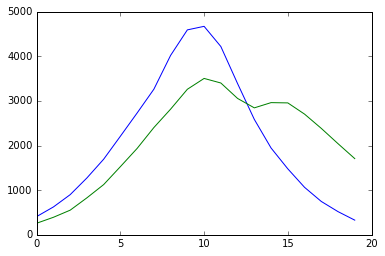

In [206]:
plt.plot(onepsfX)
plt.plot(onepsfY)

In [207]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (average, np.sqrt(variance))

In [208]:
DELTA_NBINSX=10
DELTA_NBINSY=10

In [209]:
weighted_avg_and_std(np.arange(onepsfX.shape[0]),onepsfX)

(9.3500445661513609, 3.8951782685077725)

In [210]:
weighted_avg_and_std(np.arange(onepsfY.shape[0]),onepsfY)

(11.282495408053864, 4.476753726951566)

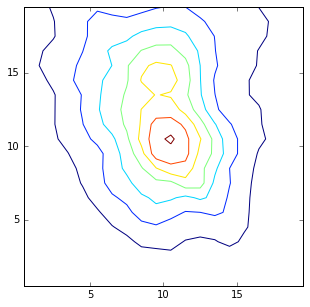

In [211]:
plt.figure(figsize=(5,5))
#onepsf2 = onepsf / np.linalg.norm(onepsf, axis=-1)[:, np.newaxis]
onepsf2 = onepsf / np.sum(onepsf)
levels=np.array([1,0.682,0.75,0.89,0.94,0.96,0.97])
#plt.contour(onepsf2,levels=levels,origin='lower') matmpltlib bug
plt.contour(onepsf2,origin='lower')

In [212]:
XV=np.arange(2*DELTA_NBINSX)-DELTA_NBINSX
YV=np.arange(2*DELTA_NBINSY)-DELTA_NBINSY
Xgrid,Ygrid=np.meshgrid(XV,YV)

In [213]:
weighted_avg_and_std(Xgrid,onepsf2)

(-0.64995543384864085, 3.8951782685077729)

In [214]:
weighted_avg_and_std(Ygrid,onepsf2)

(1.282495408053866, 4.4767537269515669)

### Estimation of PRF (PSF) for a bunch of stars


I could not use any of the utilities function.
It lacks of working examples

In [215]:
import photutils.psf 
from photutils.psf import psf_photometry

In [216]:
from astropy.modeling import models, fitting

In [217]:
import photutils
from photutils import psf

photutils.__version__

u'0.3.dev1833'

### Extraction of a few stars for visualization

In [218]:
DELTA_NBINSX=10
DELTA_NBINSY=10

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


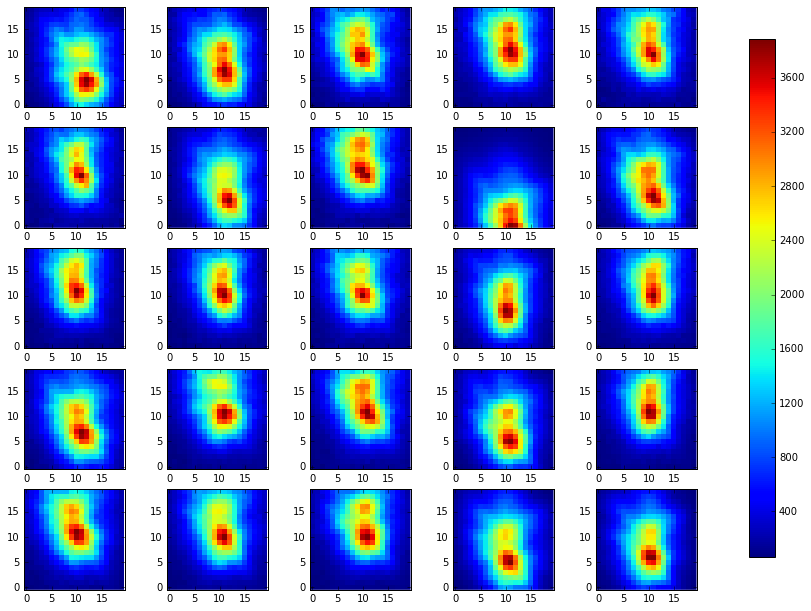

In [219]:
fig, axes = plt.subplots(nrows=5, ncols=5)
fig.set_size_inches(12, 9)
# Plot kernels
for i in range(5):
    for j in range(5):
        index=5*i+j
        if index <NBSTARS :
            prf_image = data2[YY[index]-DELTA_NBINSY:YY[index]+DELTA_NBINSY,XX[index]-DELTA_NBINSX:XX[index]+DELTA_NBINSX]
            im = axes[i, j].imshow(prf_image, interpolation='None',origin='lower')
			
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
plt.colorbar(im, cax=cax)
plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05)
plt.show()

In [220]:
selected_stars=sources.as_array()

NB_OF_STARS=selected_stars.shape[0]
SIGMAX_OF_STARS=np.zeros(NB_OF_STARS)
SIGMAY_OF_STARS=np.zeros(NB_OF_STARS)
for istar in range(selected_stars.shape[0]):
    XXs = int(selected_stars[istar][1])
    YYs = int(selected_stars[istar][2])   
    star_image = data2[YYs-DELTA_NBINSY:YYs+DELTA_NBINSY,XXs-DELTA_NBINSX:XXs+DELTA_NBINSX]
    thepsf = star_image / np.sum(star_image)
    SIGMAX_OF_STARS[istar]=weighted_avg_and_std(Xgrid,thepsf)[1]
    SIGMAY_OF_STARS[istar]=weighted_avg_and_std(Ygrid,thepsf)[1]

In [221]:
SIGMAX_OF_STARS

array([ 3.99949594,  3.8302042 ,  3.89517827,  3.76707455,  3.75138566,
        3.60869608,  3.89492588,  3.83388792,  4.1038895 ,  3.93589506,
        3.63125983,  3.58610524,  3.84347178,  3.66059134,  3.70957312,
        3.95009986,  3.91963166,  3.84119074,  3.85194668,  3.57821029,
        3.86697679,  3.84160015,  3.76974187,  3.88902354,  3.72163912,
        3.71062481,  3.82280271,  3.67684951,  3.65389368,  3.88061545,
        3.7528355 ,  3.80511429,  3.6727305 ,  3.67743176,  3.85627103,
        3.80724949])

In [222]:
SIGMAY_OF_STARS

array([ 5.01808354,  4.75465523,  4.47675373,  4.36303778,  4.33045256,
        4.36699326,  4.9326923 ,  4.29410076,  4.29157963,  4.82658075,
        4.32328304,  4.29244886,  4.36929885,  4.62916186,  4.30355373,
        4.84884046,  4.40889666,  4.31908413,  4.7808918 ,  4.19936953,
        4.38640604,  4.49973539,  4.2721976 ,  4.89689528,  4.76366386,
        4.7745605 ,  4.48477672,  4.39406413,  4.40739976,  4.6619065 ,
        4.75229845,  4.23000804,  4.34548772,  4.62169667,  4.41051372,
        3.80989361])

#### Cut NAN

In [223]:
all_sigx=SIGMAX_OF_STARS[np.logical_not(np.isnan(SIGMAX_OF_STARS))]
all_sigy=SIGMAY_OF_STARS[np.logical_not(np.isnan(SIGMAY_OF_STARS))]

#### Cut too low values

In [224]:
all_sigx=all_sigx[all_sigx>2.4]
all_sigy=all_sigy[all_sigy>2.4]

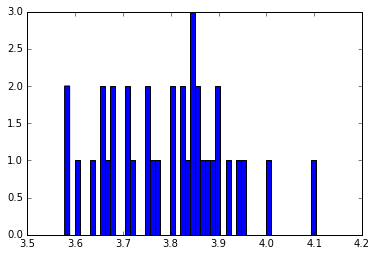

In [225]:
h1=plt.hist(all_sigx,50)

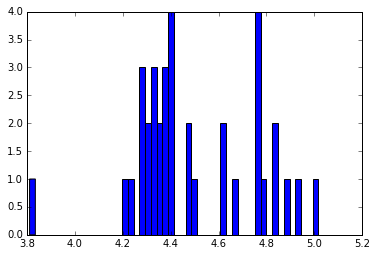

In [226]:
h1=plt.hist(all_sigy,50)

In [227]:
all_sigx.mean()

3.7943920507025388

In [228]:
print 'average prf(x) = {:2.2f} +/- {:2.2f} pixels ==> psf  {:2.2f} +/- {:2.2f} arcsec '.format(all_sigx.mean(),all_sigx.std(),all_sigx.mean()*0.4*2.36,all_sigx.std()*0.4*2.26)
print 'average prf(y) = {:2.2f} +/- {:2.2f} pixels ==> psf  {:2.2f} +/- {:2.2f} arcsec '.format(all_sigy.mean(),all_sigy.std(),all_sigy.mean()*0.4*2.36,all_sigy.std()*0.4*2.26)

average prf(x) = 3.79 +/- 0.12 pixels ==> psf  3.58 +/- 0.11 arcsec 
average prf(y) = 4.50 +/- 0.25 pixels ==> psf  4.24 +/- 0.23 arcsec 


In [ ]:
print 'average prf(x) = {:2.2f} +/- {:2.2f} pixels ==> psf  {:2.2f} +/- {:2.2f} arcsec '.format(np.median(all_sigx),all_sigx.std(),np.median(all_sigx)*0.4*2.36,all_sigx.std()*0.4*2.26)
print 'average prf(y) = {:2.2f} +/- {:2.2f} pixels ==> psf  {:2.2f} +/- {:2.2f} arcsec '.format(np.median(all_sigy),all_sigy.std(),np.median(all_sigy)*0.4*2.36,all_sigy.std()*0.4*2.26)